In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime

# Задача 1 

Мы рассмотрели несколько вариантов добавления эффекта. Есть ли смысл думать о способе добавления эффекта при оценке вероятности ошибки II рода или все способы дают одинаковый результат? Результаты могут быть разными. Чтобы в этом убедиться, проведём численный эксперимент.

Допустим, в наш А/В-тест попадают все пользователи, совершавшие покупки до 28 марта.

 
Целевая метрика — средняя выручка с клиента за время эксперимента. Целевую метрику считаем на неделе с 21 по 28 марта. Уровень значимости — 0.05. Критерий — тест Стьюдента. Размер групп — 1000. Ожидаемый эффект — средняя выручка увеличится на 10%.

Нужно оценить вероятности ошибок II рода для трёх вариантов добавления эффекта:

1. Добавление константы ко всем значениям;

2. Умножение на константу всех значений;

3. Добавление константы к 2.5% значений.

В качестве ответа введите номера способов добавления эффекта в порядке увеличения оценки вероятности ошибки II рода. Например, если при добавлении константы ко всем значениям оценка вероятности ошибки минимальна, при добавлении константы к 2.5% значений максимальна, то ответ будет: 123.

In [2]:
sales = pd.read_csv("2022-04-01T12_df_sales.csv")

In [3]:
sales["date"] = pd.to_datetime(sales["date"])

begin_date = datetime(2022, 3, 21)
end_date = datetime(2022, 3, 28)
df_users = sales[sales["date"] < end_date][["user_id"]].drop_duplicates()
df_metrics = (
    sales[(sales["date"] >= begin_date) & (sales["date"] < end_date)]
    .groupby("user_id")[["price"]]
    .sum()
    .reset_index()
)
df = pd.merge(df_users, df_metrics, on="user_id", how="left").fillna(0)

In [4]:
def plot_pvalue_ecdf(pvalues, alpha=0.05, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat="density")
    ax1.plot([0, 1], [1, 1], "k--")
    ax1.set(xlabel="p-value", ylabel="Density")

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0, 1], [0, 1], "k--")
    ax2.axvline(alpha, color="black")
    ax2.set(xlabel="p-value", ylabel="Probability")
    ax2.grid()

In [5]:
sample_size = 1000
alpha = 0.05
mde = 0.1

p_values_first_method = []
p_values_second_method = []
p_values_third_method = []

mean = df["price"].mean()
std = df["price"].std()
users = df["user_id"].unique().tolist()

for _ in tqdm(range(10000)):
    np.random.shuffle(users)
    group_a, group_b = (
        users[:sample_size],
        users[sample_size : sample_size * 2],
    )
    control = df[df["user_id"].isin(group_a)]["price"]
    test = df[df["user_id"].isin(group_b)]["price"]
    test_b_first_method = test + mean * mde
    test_b_second_method = test * (1 + mde)

    np.random.shuffle(group_b)
    group_b_part_a = np.random.choice(
        group_b, size=int(round(sample_size * 0.025, 0)), replace=False
    )
    # Добираем оставшиеся значения
    group_b_part_b = np.setdiff1d(group_b, group_b_part_a)
    test_third_method_part_1 = df[df["user_id"].isin(group_b_part_a)][
        "price"
    ] + mde * mean * sample_size / len(group_b_part_a)
    test_third_method_part_2 = df[df["user_id"].isin(group_b_part_b)]["price"]
    test_b_third_method = pd.concat(
        [test_third_method_part_1, test_third_method_part_2]
    )

    p_values_first_method.append(
        stats.ttest_ind(control, test_b_first_method).pvalue
    )
    p_values_second_method.append(
        stats.ttest_ind(control, test_b_second_method).pvalue
    )
    p_values_third_method.append(
        stats.ttest_ind(control, test_b_third_method).pvalue
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
errors_first_method = (np.array(p_values_first_method) > alpha).astype(int)
errors_second_method = (np.array(p_values_second_method) > alpha).astype(int)
errors_third_method = (np.array(p_values_third_method) > alpha).astype(int)

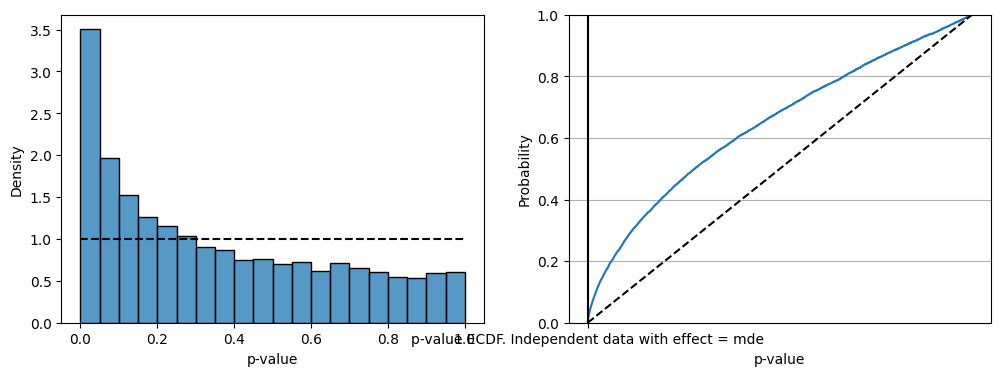

In [7]:
plot_pvalue_ecdf(
    p_values_first_method, "p-value ECDF. Independent data with effect = mde"
)

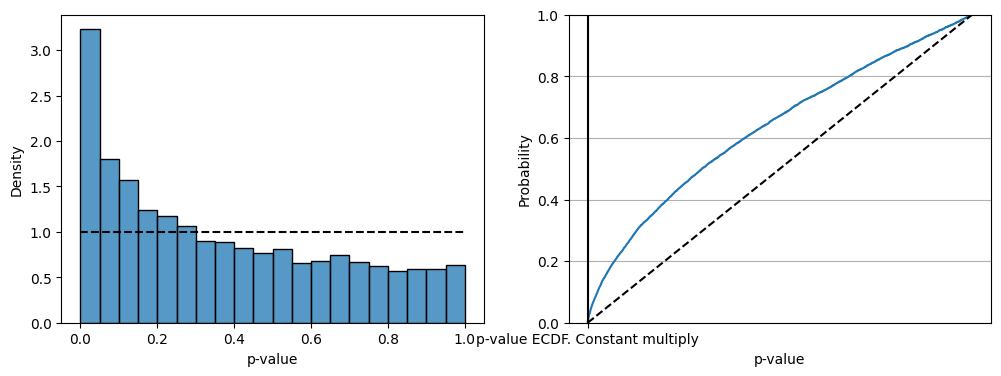

In [8]:
plot_pvalue_ecdf(p_values_second_method, "p-value ECDF. Constant multiply")

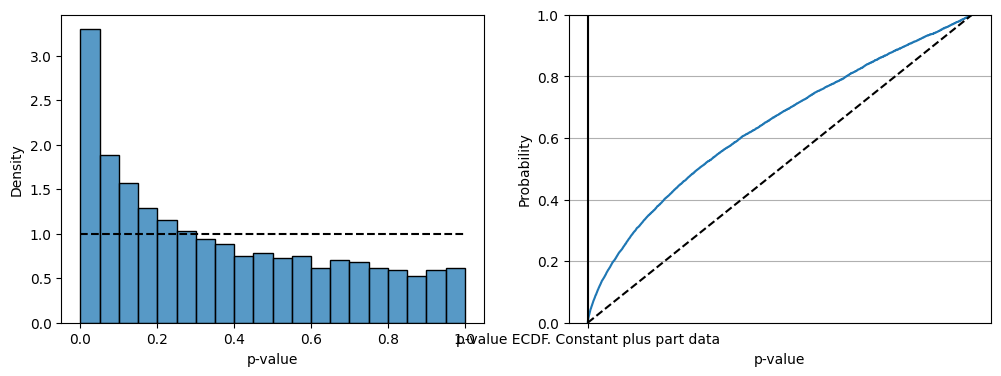

In [9]:
plot_pvalue_ecdf(
    p_values_third_method, "p-value ECDF. Constant plus part data"
)

In [10]:
print(f"part errors, first method = {np.mean(errors_first_method):0.4f}")
print(f"part errors, second method = {np.mean(errors_second_method):0.4f}")
print(f"part errors, third method = {np.mean(errors_third_method):0.4f}")

part errors, first method = 0.8249
part errors, second method = 0.8386
part errors, third method = 0.8353
